## Read the Original Image

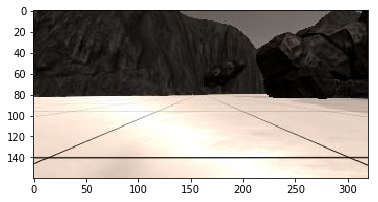

In [16]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
# This enables the interactive matplotlib window
#%matplotlib notebook
image = mpimg.imread('example_grid1.jpg')
plt.imshow(image)
plt.show()

## Project the Original  Image to Top-down View
- Set the position of 4 original points and its destination position
- Get the M matrix accourding to the 8 positions
- Use `cv.warpPerspective` to transfer the image

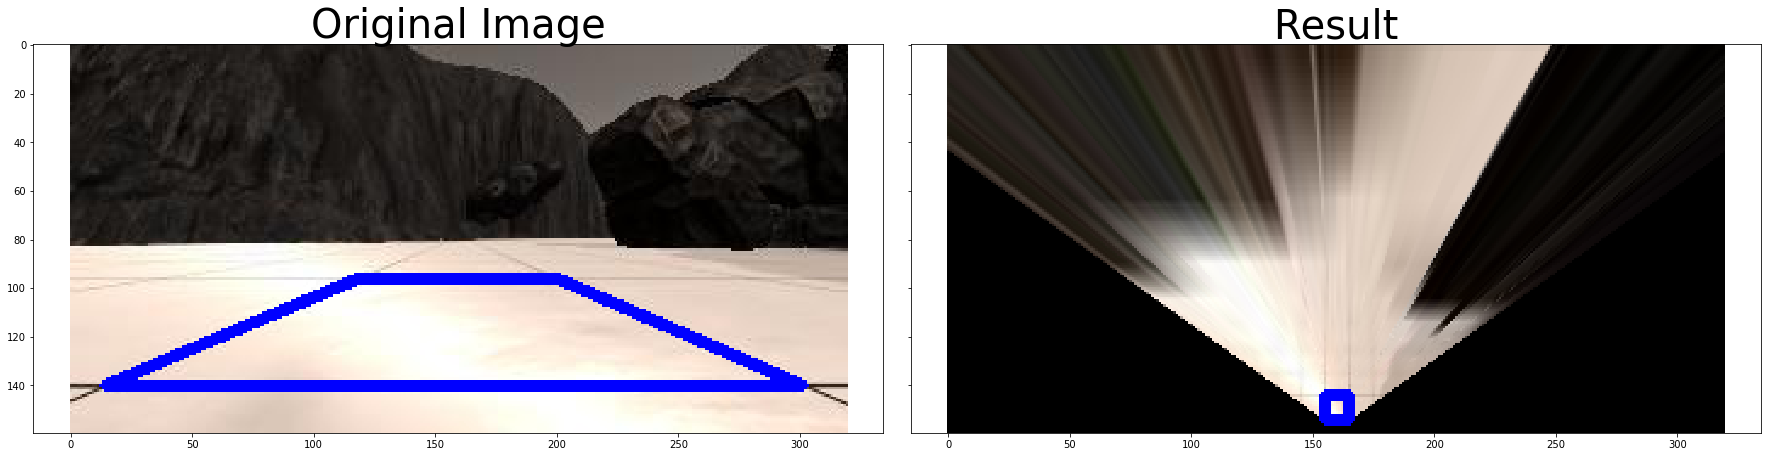

In [19]:
import cv2
import numpy as np

def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

# Assuming the destination square is 5x5 pixel
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])  

warped = perspect_transform(image, source, destination)
warped_original = warped.copy()

# Draw Source and destination points on images (in blue) before plotting
cv2.polylines(image, np.int32([source]), True, (0, 0, 255), 3)
cv2.polylines(warped, np.int32([destination]), True, (0, 0, 255), 3)
# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

## Threshold the Warped Image and Aligned the Coordination

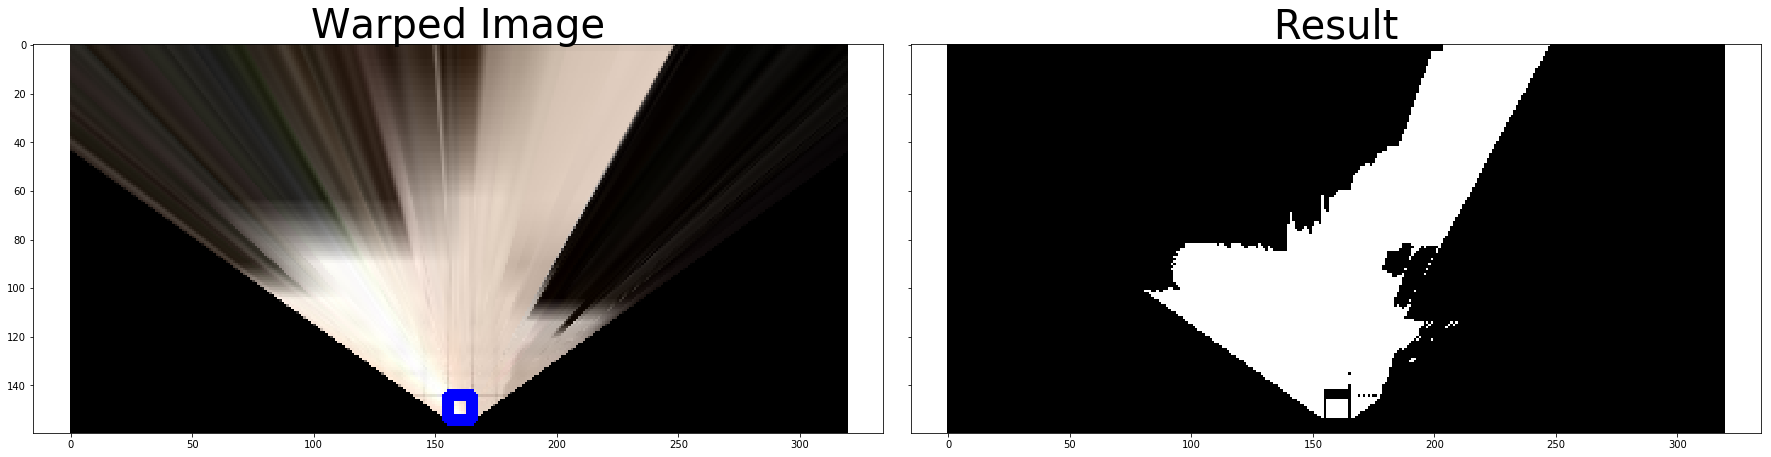

In [23]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select


colorsel = color_thresh(warped_original, rgb_thresh=(170, 170, 170))

# Display the warped image and the threhold image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=40)

ax2.imshow(colorsel, cmap='gray')
ax2.set_title('Threhold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

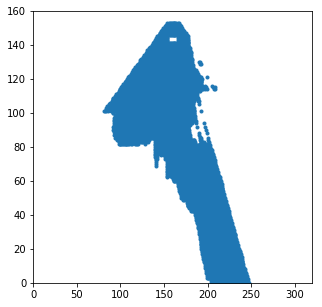

In [96]:
# Numpy gives coordinates in (row, col) = (y, x)
# OpenCV gives coordinates in (x, y) = (col, row)
ypos, xpos = colorsel.nonzero()
fig = plt.figure(figsize=(5, 5))
plt.plot(xpos, ypos, '.')
plt.ylim(0, 160)
plt.xlim(0, 320)
plt.show()

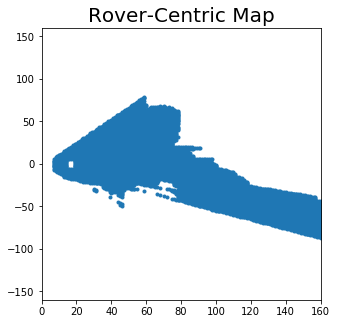

In [97]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    
    # Step 1: Remove to center
    #         x' = x - 160    y' = y - 160
    # Step 2: Change X and Y axis
    #         x' = y          y' = x
    # Step 3: Rotate back to original coordinate
    #         x' = -x         y' = -y
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
        
    return x_pixel, y_pixel

# colorsel.shape[0] = 160
# colorsel.shape[1]/2 = 160

xpix, ypix = rover_coords(colorsel)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
plt.show() # Uncomment if running on your local machine